In [ ]:
# Cell 1 – imports
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

# Reproducibility
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [2]:
# Cell 2 – load the hourly series
df = pd.read_csv("../data/ts2024.csv", parse_dates=["DateTime"])
df = df.sort_values("DateTime").reset_index(drop=True)

# Target column to forecast
TARGET_COL = "X"          # rename if needed

print(df.tail(5))
print(df[TARGET_COL].isna().sum(), "NaNs (should equal 744 for the test window)")


                  DateTime        Date  Hour   X
17539  2016-12-31 19:00:00  2016-12-31    19 NaN
17540  2016-12-31 20:00:00  2016-12-31    20 NaN
17541  2016-12-31 21:00:00  2016-12-31    21 NaN
17542  2016-12-31 22:00:00  2016-12-31    22 NaN
17543  2016-12-31 23:00:00  2016-12-31    23 NaN
744 NaNs (should equal 744 for the test window)


In [3]:
# Cell 3 – split indices
H_VAL  = 744    # 31 days of hours
H_TEST = 744

n_total = len(df)
idx_test_start = n_total - H_TEST
idx_val_start  = n_total - H_TEST - H_VAL

train_df = df.iloc[:idx_val_start].copy()
val_df   = df.iloc[idx_val_start:idx_test_start].copy()
test_df  = df.iloc[idx_test_start:].copy()   # X contains NaNs

print(f"train {train_df.shape}, val {val_df.shape}, test {test_df.shape}")

train (16056, 4), val (744, 4), test (744, 4)


In [4]:
# Cell 4 – scale the target
scaler = MinMaxScaler()
train_df[TARGET_COL] = scaler.fit_transform(train_df[[TARGET_COL]])
val_df  [TARGET_COL] = scaler.transform(val_df[[TARGET_COL]])
# keep test NaNs untouched – we’ll create placeholders later

In [5]:
# Cell 5 – turn series into supervised windows
def make_windows(series: np.ndarray, lookback: int, horizon: int = 1):
    """
    Returns X, y numpy arrays ready for Keras
    """
    X, y = [], []
    for i in range(len(series) - lookback - horizon + 1):
        window = series[i : i + lookback]
        label  = series[i + lookback : i + lookback + horizon]
        if np.isnan(window).any() or np.isnan(label).any():
            # skip windows that cross NaNs (important for test)
            continue
        X.append(window)
        y.append(label)
    return np.array(X)[..., np.newaxis], np.array(y)

LOOKBACK = 168        # one week of hourly data
HORIZON  = 1          # predict one hour ahead

x_train, y_train = make_windows(train_df[TARGET_COL].values, LOOKBACK, HORIZON)
x_val,   y_val   = make_windows(  val_df[TARGET_COL].values, LOOKBACK, HORIZON)

print(x_train.shape, y_train.shape, x_val.shape, y_val.shape)

(15888, 168, 1) (15888, 1) (576, 168, 1) (576, 1)


In [6]:
# Cell 6 – model builder
def build_lstm(units: int = 64,
               lookback: int = LOOKBACK,
               horizon: int = HORIZON,
               n_layers: int = 1,
               dropout: float = 0.0):
    inputs = layers.Input(shape=(lookback, 1))
    x = inputs
    for i in range(n_layers - 1):
        x = layers.LSTM(units, return_sequences=True)(x)
        if dropout:
            x = layers.Dropout(dropout)(x)
    x = layers.LSTM(units)(x)
    outputs = layers.Dense(horizon)(x)
    model = models.Model(inputs, outputs, name=f"LSTM_{n_layers}x{units}")
    model.compile(
        loss="mae",           
        optimizer=tf.keras.optimizers.Adam(1e-3),
        metrics=["mae"]
    )
    return model

model_base = build_lstm()

model_base.summary()


Model: "LSTM_1x64"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 168, 1)]          0         
                                                                 
 lstm (LSTM)                 (None, 64)                16896     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 16961 (66.25 KB)
Trainable params: 16961 (66.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [7]:
# Cell 7 – fit baseline
EPOCHS = 20
BATCH  = 64

early = callbacks.EarlyStopping(patience=5, restore_best_weights=True)

hist = model_base.fit(
    x_train, y_train,
    epochs=EPOCHS, batch_size=BATCH,
    validation_data=(x_val, y_val),
    callbacks=[early],
    verbose=2
)

Epoch 1/20


249/249 - 10s - loss: 0.0409 - mae: 0.0409 - val_loss: 0.0322 - val_mae: 0.0322 - 10s/epoch - 42ms/step
Epoch 2/20
249/249 - 8s - loss: 0.0256 - mae: 0.0256 - val_loss: 0.0245 - val_mae: 0.0245 - 8s/epoch - 34ms/step
Epoch 3/20
249/249 - 8s - loss: 0.0217 - mae: 0.0217 - val_loss: 0.0207 - val_mae: 0.0207 - 8s/epoch - 33ms/step
Epoch 4/20
249/249 - 8s - loss: 0.0204 - mae: 0.0204 - val_loss: 0.0204 - val_mae: 0.0204 - 8s/epoch - 34ms/step
Epoch 5/20
249/249 - 9s - loss: 0.0198 - mae: 0.0198 - val_loss: 0.0223 - val_mae: 0.0223 - 9s/epoch - 34ms/step
Epoch 6/20
249/249 - 9s - loss: 0.0195 - mae: 0.0195 - val_loss: 0.0188 - val_mae: 0.0188 - 9s/epoch - 35ms/step
Epoch 7/20
249/249 - 9s - loss: 0.0192 - mae: 0.0192 - val_loss: 0.0189 - val_mae: 0.0189 - 9s/epoch - 36ms/step
Epoch 8/20
249/249 - 9s - loss: 0.0189 - mae: 0.0189 - val_loss: 0.0189 - val_mae: 0.0189 - 9s/epoch - 38ms/step
Epoch 9/20
249/249 - 10s - loss: 0.0189 - mae: 0.0189 - val_loss: 0.0191 - val_mae: 0.0191 -

In [8]:
# Cell 8 – evaluate on validation set
val_pred_scaled = model_base.predict(x_val, verbose=0)
val_mae = mean_absolute_error(y_val, val_pred_scaled)
print(f"Baseline val MAE (scaled): {val_mae:.4f}")

# store results for the leaderboard
benchmark = []
benchmark.append(
    {"model": model_base.name, "val_MAE_scaled": val_mae}
)
pd.DataFrame(benchmark)

Baseline val MAE (scaled): 0.0187


,model,val_MAE_scaled
0,LSTM_1x64,0.01868


In [9]:
# Cell 9 – recursive (walk-forward) forecasting for the 744 h test window
def recursive_forecast(model, last_window, steps, scaler, lookback):
    """
    last_window – ndarray shape (lookback,)
    returns list of scaled predictions
    """
    preds = []
    window = last_window.copy()
    for _ in range(steps):
        x = window[-lookback:][np.newaxis, ..., np.newaxis]
        yhat = model.predict(x, verbose=0)[0,0]
        preds.append(yhat)
        window = np.append(window, yhat)
    return np.array(preds)

# create the seed window: last `LOOKBACK` values before the test gap
seed_series = pd.concat([train_df, val_df])[TARGET_COL].values
seed_window = seed_series[-LOOKBACK:]

test_pred_scaled = recursive_forecast(model_base,
                                      seed_window,
                                      H_TEST,
                                      scaler,
                                      LOOKBACK)

# Inverse-transform back to original scale
test_pred = scaler.inverse_transform(test_pred_scaled.reshape(-1,1)).flatten()

# Save for later inspection
test_df[f"{TARGET_COL}_forecast"] = test_pred
test_df.head()

,DateTime,Date,Hour,X,X_forecast
16800,2016-12-01,2016-12-01,0,NaN,0.004537
16801,2016-12-01 01:00:00,2016-12-01,1,NaN,0.001865
16802,2016-12-01 02:00:00,2016-12-01,2,NaN,0.004641
16803,2016-12-01 03:00:00,2016-12-01,3,NaN,0.015890
16804,2016-12-01 04:00:00,2016-12-01,4,NaN,0.036872


In [10]:
# Cell 10 – template for new experiments
def experiment(name: str,
               units: int = 128,
               n_layers: int = 2,
               dropout: float = 0.2):
    model = build_lstm(units=units, n_layers=n_layers, dropout=dropout)
    model.fit(
        x_train, y_train,
        epochs=EPOCHS, batch_size=BATCH,
        validation_data=(x_val, y_val),
        callbacks=[early],
        verbose=0
    )
    mae_val = mean_absolute_error(y_val, model.predict(x_val, verbose=0))
    benchmark.append({"model": name,
                      "val_MAE_scaled": mae_val})
    print(f"{name}: val MAE={mae_val:.4f}")
    return model

# ==== Example runs ====
model_deeper = experiment("LSTM_2x128_dropout",
                          units=128, n_layers=2, dropout=0.2)

model_gru = experiment("GRU_2x64",
                       units=64, n_layers=2, dropout=0.0)  # change build_fn if using GRU

pd.DataFrame(benchmark).sort_values("val_MAE_scaled")

LSTM_2x128_dropout: val MAE=0.0179
GRU_2x64: val MAE=0.0180


,model,val_MAE_scaled
0,LSTM_1x64,0.017891
1,LSTM_2x128_dropout,0.017944
2,GRU_2x64,0.018005


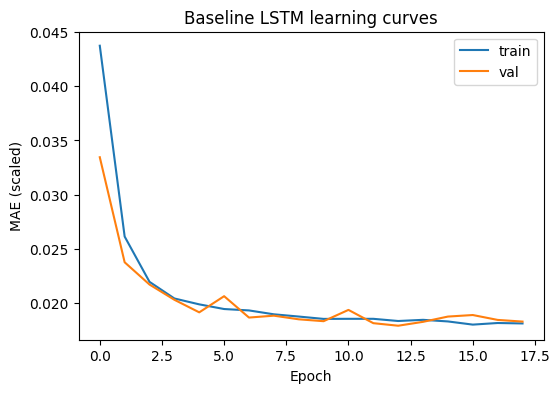

In [11]:
# Cell 11
plt.figure(figsize=(6,4))
plt.plot(hist.history["mae"], label="train")
plt.plot(hist.history["val_mae"], label="val")
plt.title("Baseline LSTM learning curves")
plt.xlabel("Epoch")
plt.ylabel("MAE (scaled)")
plt.legend()
plt.show()


In [11]:
pip install tqdm

  Using cached tqdm-4.67.1-py3-none-any.whl (78 kB)
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [12]:
# Cell 13 – grid-search on "units" keeping a single LSTM layer
from tqdm.auto import tqdm

UNIT_GRID = [16, 32, 64, 128] #, 256]     # <- adjust/extend if desired
hp_results = []

for units in tqdm(UNIT_GRID):
    tag = f"LSTM_1x{units}"
    model = build_lstm(units=units,               # <-- n_layers fixed to 1
                       n_layers=1,
                       dropout=0.0)               # <-- no dropout
    model.fit(
        x_train, y_train,
        epochs=EPOCHS, batch_size=BATCH,
        validation_data=(x_val, y_val),
        callbacks=[early],
        verbose=0
    )
    mae_val = mean_absolute_error(y_val, model.predict(x_val, verbose=0))
    hp_results.append({"tag": tag,
                       "units": units,
                       "val_MAE_scaled": mae_val})
    print(f"{tag:14s} – val MAE_scaled = {mae_val:.5f}")

hp_df = (pd.DataFrame(hp_results)
           .sort_values("val_MAE_scaled")
           .reset_index(drop=True))
hp_df.head()

c:\Users\Utente\time series\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
 25%|██▌       | 1/4 [01:53<05:39, 113.10s/it]

LSTM_1x16      – val MAE_scaled = 0.01856


 50%|█████     | 2/4 [04:07<04:11, 125.61s/it]

LSTM_1x32      – val MAE_scaled = 0.01855


 75%|███████▌  | 3/4 [06:26<02:11, 131.90s/it]

LSTM_1x64      – val MAE_scaled = 0.01805


100%|██████████| 4/4 [10:14<00:00, 153.70s/it]

LSTM_1x128     – val MAE_scaled = 0.01795


,tag,units,val_MAE_scaled
0,LSTM_1x128,128,0.017946
1,LSTM_1x64,64,0.018052
2,LSTM_1x32,32,0.018547
3,LSTM_1x16,16,0.018557


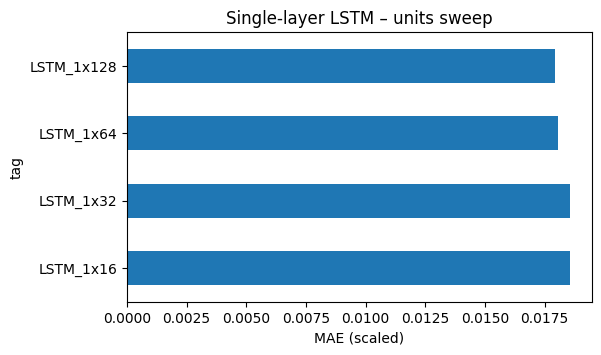

,tag,units,val_MAE_scaled
0,LSTM_1x128,128,0.017946
1,LSTM_1x64,64,0.018052
2,LSTM_1x32,32,0.018547
3,LSTM_1x16,16,0.018557


In [13]:
# Cell 14 – bar-plot of validation MAE for each units choice
plt.figure(figsize=(6, 3.5))
hp_df.set_index("tag")["val_MAE_scaled"].plot.barh()
plt.xlabel("MAE (scaled)")
plt.title("Single-layer LSTM – units sweep")
plt.gca().invert_yaxis()
plt.show()

hp_df   # full table

In [14]:
# Cell 15 – final fit using the best "units" setting
best_units = int(hp_df.iloc[0]["units"])
print(f"Best config ➜ 1 layer, {best_units} units")

# merge train and val (already scaled)
full_df = pd.concat([train_df, val_df]).reset_index(drop=True)

x_full, y_full = make_windows(full_df[TARGET_COL].values, LOOKBACK, HORIZON)
print("Train+Val windows:", x_full.shape)

best_model = build_lstm(units=best_units,
                        n_layers=1,
                        dropout=0.0)

hist_full = best_model.fit(
    x_full, y_full,
    epochs=EPOCHS, batch_size=BATCH,
    callbacks=[early],
    verbose=2
)

best_model.save("best_final_lstm_single_layer.h5")


Best config ➜ 1 layer, 128 units
Train+Val windows: (16632, 168, 1)
Epoch 1/20
260/260 - 22s - loss: 0.0375 - mae: 0.0375 - 22s/epoch - 86ms/step
Epoch 2/20
260/260 - 21s - loss: 0.0234 - mae: 0.0234 - 21s/epoch - 81ms/step
Epoch 3/20
260/260 - 22s - loss: 0.0206 - mae: 0.0206 - 22s/epoch - 83ms/step
Epoch 4/20
260/260 - 21s - loss: 0.0200 - mae: 0.0200 - 21s/epoch - 83ms/step
Epoch 5/20
260/260 - 21s - loss: 0.0195 - mae: 0.0195 - 21s/epoch - 81ms/step
Epoch 6/20
260/260 - 21s - loss: 0.0192 - mae: 0.0192 - 21s/epoch - 81ms/step
Epoch 7/20
260/260 - 21s - loss: 0.0192 - mae: 0.0192 - 21s/epoch - 81ms/step
Epoch 8/20
260/260 - 21s - loss: 0.0188 - mae: 0.0188 - 21s/epoch - 81ms/step
Epoch 9/20


KeyboardInterrupt: 

In [17]:
# Cell 16 – new feature engineering relying on 'Date' + 'Hour'

import numpy as np

def add_time_features(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()

    # --- ensure correct dtypes ---
    df["Date"] = pd.to_datetime(df["Date"])          # safe even if already datetime
    # 'Hour' column is already int (0-23) in your screenshot

    # calendar components
    df["hour"]  = df["Hour"]                         # duplicate for clarity
    df["dow"]   = df["Date"].dt.dayofweek            # 0 = Monday
    df["month"] = df["Date"].dt.month               # 1–12

    # cyclic encodings
    df["hour_sin"]  = np.sin(2*np.pi*df["hour"] / 24)
    df["hour_cos"]  = np.cos(2*np.pi*df["hour"] / 24)
    df["dow_sin"]   = np.sin(2*np.pi*df["dow"]  / 7)
    df["dow_cos"]   = np.cos(2*np.pi*df["dow"]  / 7)
    df["month_sin"] = np.sin(2*np.pi*df["month"]/12)
    df["month_cos"] = np.cos(2*np.pi*df["month"]/12)

    return df

df_fe = add_time_features(df)        # <— original dataframe from earlier cells

# keep the same split indices defined earlier (idx_val_start / idx_test_start)
train_df_fe = df_fe.iloc[:idx_val_start].copy()
val_df_fe   = df_fe.iloc[idx_val_start:idx_test_start].copy()
test_df_fe  = df_fe.iloc[idx_test_start:].copy()


In [18]:
# Cell 17 – target scaling for the new frames
scaler_fe = MinMaxScaler()
train_df_fe[TARGET_COL] = scaler_fe.fit_transform(train_df_fe[[TARGET_COL]])
val_df_fe  [TARGET_COL] = scaler_fe.transform(val_df_fe[[TARGET_COL]])
# leave test NaNs as-is; they’ll be filled when we predict

In [19]:
# Cell 18 – prepare input tensors with the new features
feature_cols = [TARGET_COL,
                "hour_sin", "hour_cos",
                "dow_sin",  "dow_cos",
                "month_sin","month_cos"]

N_FEATURES = len(feature_cols)

def make_windows_mv(df_src, lookback, horizon=1):
    feats  = df_src[feature_cols].values
    target = df_src[TARGET_COL].values
    X, y = [], []
    for i in range(len(df_src) - lookback - horizon + 1):
        win_f = feats[i:i+lookback]
        lbl   = target[i+lookback:i+lookback+horizon]
        if np.isnan(win_f).any() or np.isnan(lbl).any():
            continue
        X.append(win_f)
        y.append(lbl)
    return np.array(X), np.array(y)

x_train_fe, y_train_fe = make_windows_mv(train_df_fe, LOOKBACK, HORIZON)
x_val_fe,   y_val_fe   = make_windows_mv(val_df_fe,   LOOKBACK, HORIZON)

print("Multivariate shapes –", x_train_fe.shape, y_train_fe.shape)


Multivariate shapes – (15888, 168, 7) (15888, 1)


In [20]:
# Cell 19 – single-layer model for multivariate input
def build_lstm_mv(units=best_units, lookback=LOOKBACK,
                  horizon=HORIZON, n_features=N_FEATURES):
    inp = layers.Input(shape=(lookback, n_features))
    x   = layers.LSTM(units)(inp)
    out = layers.Dense(horizon)(x)
    mdl = models.Model(inp, out, name=f"LSTM_1x{units}_feat")
    mdl.compile(loss="mae", optimizer=tf.keras.optimizers.Adam(1e-3), metrics=["mae"])
    return mdl

model_feat = build_lstm_mv()

hist_feat = model_feat.fit(
    x_train_fe, y_train_fe,
    epochs=EPOCHS, batch_size=BATCH,
    validation_data=(x_val_fe, y_val_fe),
    callbacks=[early],
    verbose=2
)

mae_val_uni  = float(hp_df.loc[hp_df["units"]==best_units,"val_MAE_scaled"].values[0])
mae_val_feat = mean_absolute_error(y_val_fe, model_feat.predict(x_val_fe, verbose=0))

print(f"\nValidation MAE (scaled) – univariate: {mae_val_uni:.5f}   "
      f"with features: {mae_val_feat:.5f}")


Epoch 1/20
249/249 - 20s - loss: 0.0336 - mae: 0.0336 - val_loss: 0.0345 - val_mae: 0.0345 - 20s/epoch - 79ms/step
Epoch 2/20
249/249 - 17s - loss: 0.0232 - mae: 0.0232 - val_loss: 0.0251 - val_mae: 0.0251 - 17s/epoch - 69ms/step
Epoch 3/20
249/249 - 17s - loss: 0.0210 - mae: 0.0210 - val_loss: 0.0233 - val_mae: 0.0233 - 17s/epoch - 67ms/step
Epoch 4/20
249/249 - 17s - loss: 0.0197 - mae: 0.0197 - val_loss: 0.0209 - val_mae: 0.0209 - 17s/epoch - 70ms/step
Epoch 5/20
249/249 - 17s - loss: 0.0189 - mae: 0.0189 - val_loss: 0.0235 - val_mae: 0.0235 - 17s/epoch - 70ms/step
Epoch 6/20
249/249 - 18s - loss: 0.0187 - mae: 0.0187 - val_loss: 0.0206 - val_mae: 0.0206 - 18s/epoch - 72ms/step
Epoch 7/20
249/249 - 18s - loss: 0.0185 - mae: 0.0185 - val_loss: 0.0202 - val_mae: 0.0202 - 18s/epoch - 73ms/step
Epoch 8/20
249/249 - 18s - loss: 0.0182 - mae: 0.0182 - val_loss: 0.0203 - val_mae: 0.0203 - 18s/epoch - 72ms/step
Epoch 9/20
249/249 - 18s - loss: 0.0182 - mae: 0.0182 - val_loss: 0.0216 - val_m

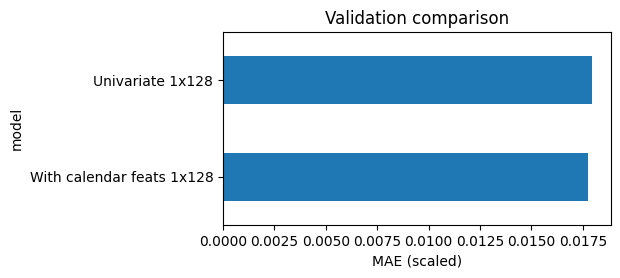

,model,val_MAE_scaled
0,Univariate 1x128,0.017946
1,With calendar feats 1x128,0.017759


In [21]:
# Cell 20 – table + bar plot
cmp = pd.DataFrame({
    "model": ["Univariate 1x128", "With calendar feats 1x128"],
    "val_MAE_scaled": [mae_val_uni, mae_val_feat]
})

# Bar plot
plt.figure(figsize=(5,2.5))
cmp.set_index("model")["val_MAE_scaled"].plot.barh()
plt.xlabel("MAE (scaled)")
plt.title("Validation comparison")
plt.gca().invert_yaxis()
plt.show()

cmp


In [22]:
# Cell 21 – fit on merged set
full_df_fe = pd.concat([train_df_fe, val_df_fe]).reset_index(drop=True)
x_full_fe, y_full_fe = make_windows_mv(full_df_fe, LOOKBACK, HORIZON)

best_model_feat = build_lstm_mv()
best_model_feat.fit(
    x_full_fe, y_full_fe,
    epochs=EPOCHS, batch_size=BATCH,
    callbacks=[early],
    verbose=2
)

best_model_feat.save("best_final_lstm_features.h5")


Epoch 1/20
260/260 - 19s - loss: 0.0333 - mae: 0.0333 - 19s/epoch - 72ms/step
Epoch 2/20
260/260 - 17s - loss: 0.0232 - mae: 0.0232 - 17s/epoch - 65ms/step
Epoch 3/20
260/260 - 17s - loss: 0.0203 - mae: 0.0203 - 17s/epoch - 66ms/step
Epoch 4/20
260/260 - 18s - loss: 0.0195 - mae: 0.0195 - 18s/epoch - 70ms/step
Epoch 5/20
260/260 - 19s - loss: 0.0190 - mae: 0.0190 - 19s/epoch - 72ms/step
Epoch 6/20
260/260 - 18s - loss: 0.0188 - mae: 0.0188 - 18s/epoch - 71ms/step
Epoch 7/20
260/260 - 19s - loss: 0.0187 - mae: 0.0187 - 19s/epoch - 73ms/step
Epoch 8/20
260/260 - 18s - loss: 0.0182 - mae: 0.0182 - 18s/epoch - 68ms/step
Epoch 9/20
260/260 - 17s - loss: 0.0183 - mae: 0.0183 - 17s/epoch - 65ms/step
Epoch 10/20
260/260 - 17s - loss: 0.0179 - mae: 0.0179 - 17s/epoch - 66ms/step
Epoch 11/20
260/260 - 17s - loss: 0.0178 - mae: 0.0178 - 17s/epoch - 66ms/step
Epoch 12/20
260/260 - 17s - loss: 0.0178 - mae: 0.0178 - 17s/epoch - 67ms/step
Epoch 13/20
260/260 - 17s - loss: 0.0178 - mae: 0.0178 - 17s/

c:\Users\Utente\time series\venv\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [23]:
# Cell 22 – recursive multivariate forecast
def recursive_forecast_mv(model, feat_arr, target_idx, start_idx,
                          steps, lookback):
    preds = []
    for t in range(steps):
        win = feat_arr[start_idx + t - lookback : start_idx + t]
        x   = win[np.newaxis, ...]
        yhat = model.predict(x, verbose=0)[0,0]
        preds.append(yhat)
        feat_arr[start_idx + t, target_idx] = yhat   # feed-back
    return np.array(preds)

# 1️⃣  scale target col in the test chunk (keeping NaNs)
test_df_fe[TARGET_COL] = scaler_fe.transform(test_df_fe[[TARGET_COL]])

# 2️⃣  concatenate history + future features
features_all = pd.concat([full_df_fe, test_df_fe]).reset_index(drop=True)
feat_arr = features_all[feature_cols].values

start_idx = len(full_df_fe)               # first row of test horizon
test_pred_scaled = recursive_forecast_mv(best_model_feat,
                                         feat_arr,
                                         target_idx=0,
                                         start_idx=start_idx,
                                         steps=H_TEST,
                                         lookback=LOOKBACK)

test_pred = scaler_fe.inverse_transform(test_pred_scaled.reshape(-1,1)).flatten()


In [24]:
# Cell 23 – write csv
submission_feat = test_df_fe[["DateTime"]].copy()
submission_feat["ML"] = test_pred

csv_path = "lstm_hourly_forecast_calendar_feats.csv"
submission_feat.to_csv(csv_path, index=False)
print(f"Saved calendar-feature forecast to {csv_path}")

submission_feat.head()

Saved calendar-feature forecast to lstm_hourly_forecast_calendar_feats.csv


,DateTime,ML
16800,2016-12-01,0.009187
16801,2016-12-01 01:00:00,0.009558
16802,2016-12-01 02:00:00,0.009935
16803,2016-12-01 03:00:00,0.016261
16804,2016-12-01 04:00:00,0.032994


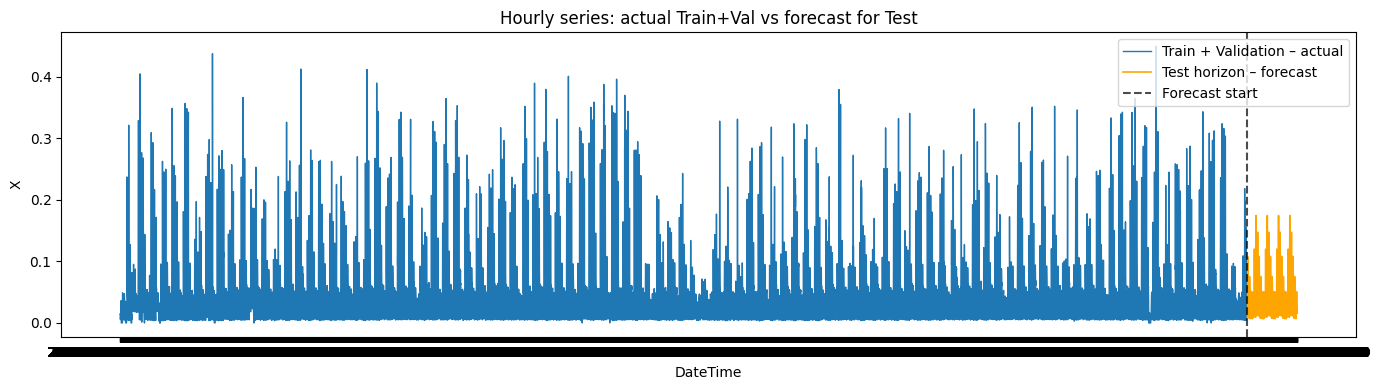

In [25]:
# Cell 24 – plot train+val actuals and test forecast
plt.figure(figsize=(14, 4))

# ---- actual data for train + val (original scale) ----
plt.plot(
    df.loc[:idx_test_start-1, "DateTime"],           # timestamps
    df.loc[:idx_test_start-1, TARGET_COL],           # original units
    label="Train + Validation – actual",
    linewidth=1.0,
)

# ---- forecast for the 744-hour test horizon ----
plt.plot(
    submission_feat["DateTime"],                     # same timeline basis
    submission_feat["ML"],
    label="Test horizon – forecast",
    linewidth=1.2,
    color="orange",
)

# vertical marker at forecast start
plt.axvline(
    x=df.loc[idx_test_start, "DateTime"],
    linestyle="--",
    color="black",
    alpha=0.7,
    label="Forecast start"
)

plt.title("Hourly series: actual Train+Val vs forecast for Test")
plt.xlabel("DateTime")
plt.ylabel(TARGET_COL)
plt.legend()
plt.tight_layout()
plt.show()
